In [1]:
from diffusion.time_scheduler import quadratic_beta_schedule
#from image_datasets.IXIdataset import IXIDataset
from image_datasets.capsSlicesADNI import get_ADNI_datasets
import torch
from torch.utils.data import DataLoader
from model.unet import Unet
from diffusion.diffusion import DiffusionModel
from torch.optim import Adam
from diffusion.sampler import sample
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from diffusion.utils import *
from utils.config import DiffusionConfig
import numpy as np

In [2]:
def name_dim_mults(dim_mults):
    name = ''
    for dim in dim_mults:
        name+=str(dim)
    return name

## Load Dataset

### Dataset IXI

In [3]:
root = "./IXI-dataset-master/size64/"
dataset = IXIDataset(root, mode="train")

channels, image_size, _ = dataset[0]['T1'].shape

batch_size = 20

<class 'NameError'>: name 'IXIDataset' is not defined

In [ ]:
def return_loaders_disjoint(train_size):
    train_set_1, train_set_2 = train_test_split(dataset, train_size=train_size, test_size=train_size)

    train_set_1_batched = []
    for i in range(int(train_size_max/train_size)):
        train_set_1_batched.extend(train_set_1)
    train_set_1 = train_set_1_batched
    
    train_set_2_batched = []
    for i in range(int(train_size_max/train_size)):
        train_set_2_batched.extend(train_set_2)
    train_set_2 = train_set_2_batched
        
    train_1_loader = DataLoader(
        train_set_1,
        batch_size=batch_size,
        shuffle=False,
    )
    train_2_loader = DataLoader(
        train_set_2,
        batch_size=batch_size,
        shuffle=False,
    )
    
    return train_1_loader, train_2_loader

def train_network(train_loader, timesteps, image_size, channels, dim_mults):
    betas = quadratic_beta_schedule(timesteps, beta_start=0.00001, beta_end=0.01)

    model = Unet(
        dim=image_size,
        channels=channels,
        dim_mults=dim_mults
    )

    model.to(device)

    nb_param = sum(p.numel() for p in model.parameters() if p.requires_grad)

    ddpm = DiffusionModel(model, timesteps, betas, device, loss_type='huber')

    optimizer = Adam(model.parameters(), lr=3e-4)

    ddpm.train(epochs, optimizer, train_loader)
    
    return ddpm

### Dataset ADNI

In [3]:
## Dataset ADNI CN
datasets = get_ADNI_datasets('ADNI_AD_CN', img_size=128)

dataset = datasets["train_init"]
#val_set = datasets["val_init"]

channels, image_size, _ = dataset[0]['image'].shape

batch_size = 20

In [4]:
def return_loaders_disjoint(train_size):
    train_set_1, train_set_2 = train_test_split(dataset, train_size=train_size, test_size=train_size)
    
    train_set_1_batched = []
    for i in range(int(train_size_max/train_size)):
        train_set_1_batched.extend(train_set_1)
    train_set_1 = train_set_1_batched
    
    train_set_2_batched = []
    for i in range(int(train_size_max/train_size)):
        train_set_2_batched.extend(train_set_2)
    train_set_2 = train_set_2_batched
        
    train_1_loader = DataLoader(
        train_set_1,
        batch_size=batch_size,
        shuffle=False,
    )
    train_2_loader = DataLoader(
        train_set_2,
        batch_size=batch_size,
        shuffle=False,
    )
    
    return train_1_loader, train_2_loader

def train_network(train_loader, timesteps, image_size, channels, dim_mults):
    #betas = quadratic_beta_schedule(timesteps, beta_start=0.00001, beta_end=0.01)
    diffusion_config = DiffusionConfig(
        timesteps = timesteps,
        beta_start = 0.00001,
        beta_end = 0.01,
        loss_type = 'huber',
    )

    model = Unet(
        dim=image_size,
        channels=channels,
        dim_mults=dim_mults
    )

    model.to(device)

    nb_param = sum(p.numel() for p in model.parameters() if p.requires_grad)

    ddpm = DiffusionModel(model, diffusion_config, device)

    optimizer = Adam(model.parameters(), lr=3e-4)

    ddpm.train(epochs, optimizer, train_loader)
    
    return ddpm

## Benchmark diffusion model

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_size_max = 400

train_sizes = [1,10,50,200] #1,10,50,100,
test_sizes = {1:1,10:10,50:50,100:100,400:40}

dim_mults = (1,2,4,)
timesteps = 1000
epochs = 200

batch_size_sampling = 10

In [6]:
# timesteps + 1 for init
noises = torch.randn((timesteps+1, batch_size_sampling, channels, image_size, image_size)).to(device)

In [7]:
train_loaders = {}
samples_train_sizes = {}



Start training!


/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.3.0+py3.11.5/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /gpfs7kro/gpfslocalsup/src/pub/anaconda-py3/2023.09/pytorch-gpu-2.3.0+py3.11.5+cuda-12.2/pytorch-2.3.0/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|##########| 200/200 [44:51<00:00, 13.46s/it]




Start training!


100%|##########| 200/200 [44:55<00:00, 13.48s/it]


1000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

1000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

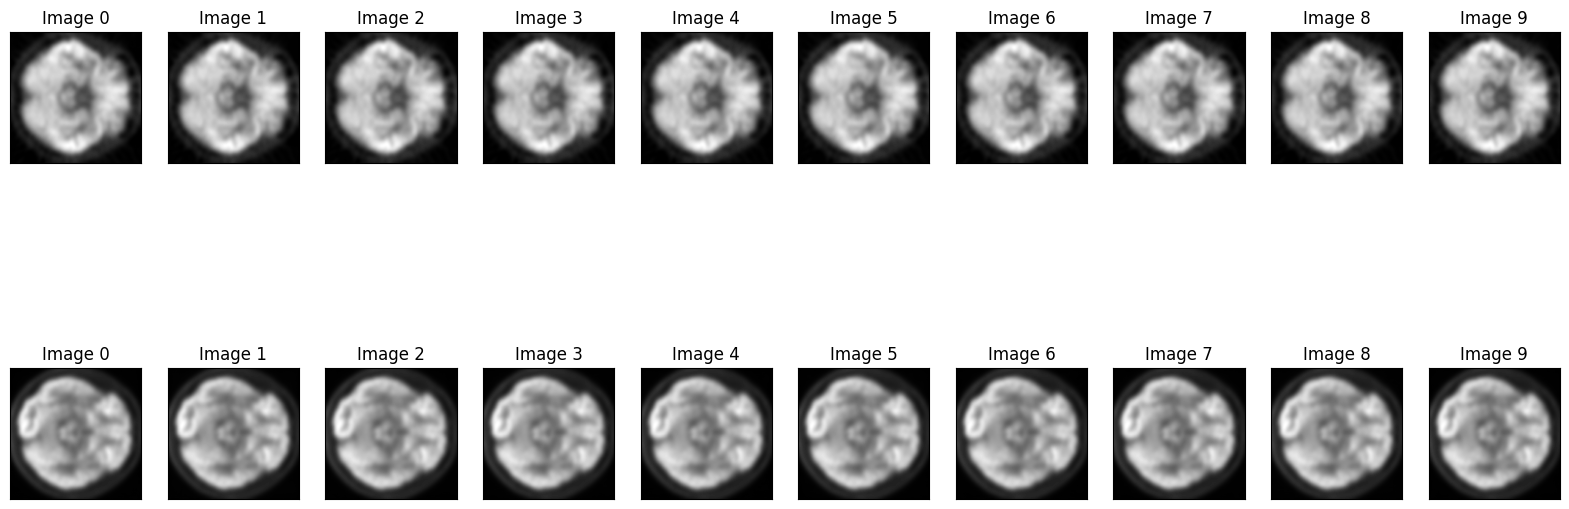



Start training!


100%|##########| 200/200 [45:03<00:00, 13.52s/it]




Start training!


100%|##########| 200/200 [45:03<00:00, 13.52s/it]


1000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

1000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

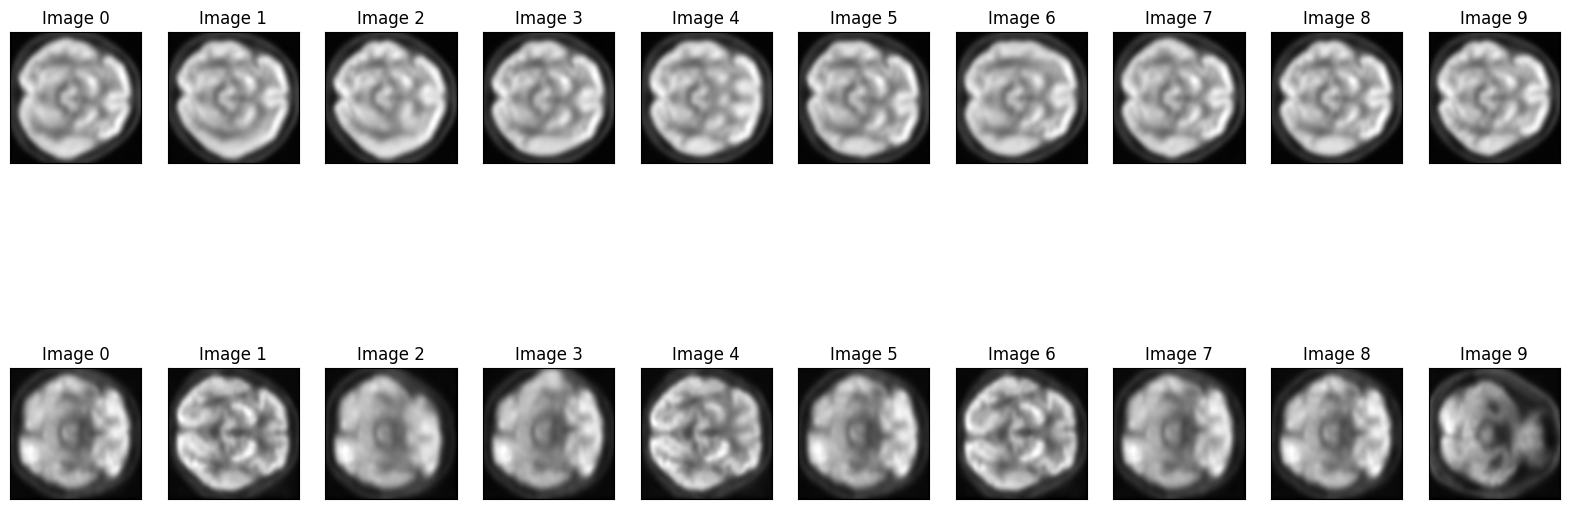



Start training!


100%|##########| 200/200 [44:54<00:00, 13.47s/it]




Start training!


100%|##########| 200/200 [44:45<00:00, 13.43s/it]


1000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

1000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

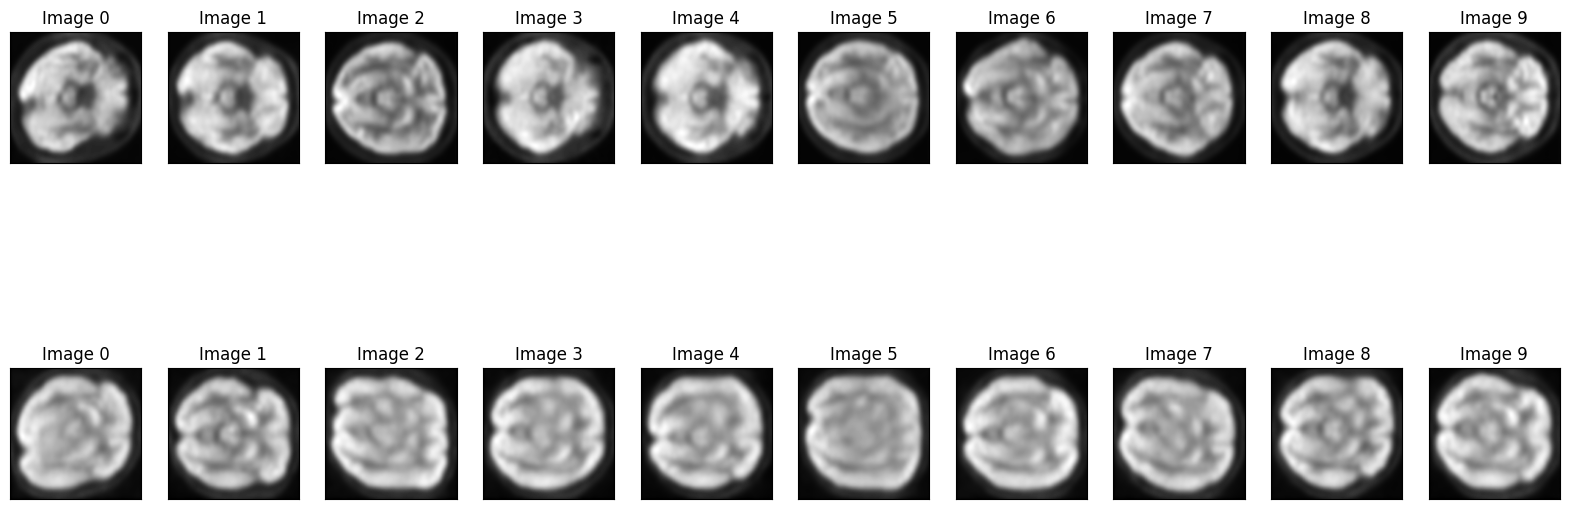



Start training!


  3%|3         | 6/200 [01:20<43:22, 13.41s/it]

In [ ]:
for idx_train_size, train_size in enumerate(train_sizes):

    train_loader_1, train_loader_2 = return_loaders_disjoint(train_size)
    
    ddpm_1 = train_network(train_loader_1, timesteps, image_size, channels, dim_mults)
    ddpm_2 = train_network(train_loader_2, timesteps, image_size, channels, dim_mults)

    # draw noise path
    noises = torch.randn((timesteps+1, batch_size_sampling, channels, image_size, image_size)).to(device)
    
    # sample 10 images from both models
    samples_1 = sample(ddpm_1, image_size=image_size, batch_size=batch_size_sampling, channels=channels, noises=noises)
    samples_2 = sample(ddpm_2, image_size=image_size, batch_size=batch_size_sampling, channels=channels, noises=noises)

    samples_train_sizes[train_size] = (samples_1, samples_2)
    train_loaders[train_size] = (train_loader_1, train_loader_2)
    
    start = 0
    end = -1

    fig, axs = plt.subplots(2, 10, figsize=(20, 8))
    for i in range(10):
        axs[0,i].get_xaxis().set_visible(False)
        axs[0,i].get_yaxis().set_visible(False)
        axs[0,i].set_title(f"Image {i}")
        axs[0,i].imshow(samples_1[-1][i].reshape(image_size, image_size, channels), cmap="gray")
        
        axs[1,i].get_xaxis().set_visible(False)
        axs[1,i].get_yaxis().set_visible(False)
        axs[1,i].set_title(f"Image {i}")
        axs[1,i].imshow(samples_2[-1][i].reshape(image_size, image_size, channels), cmap="gray")

    plt.show()

In [ ]:
def nearest_neighbor_train_set(sample, train_set):
    idx_nearest_neighbor = 0
    nearest_neighbor_dist = 1 #(sample**2).mean()
    nearest_neighbor = 0
    
    cpt = 0
    for train_set_batch in train_set:
        nearest_neighbor_batch_dist = torch.min(((train_set_batch["image"].to(torch.float)-sample)**2).mean(-1).mean(-1)[:,0])
        idx_nearest_neighbor_batch = torch.argmin(((train_set_batch["image"].to(torch.float)-sample)**2).mean(-1).mean(-1)[:,0])
        
        if nearest_neighbor_dist>nearest_neighbor_batch_dist:
            idx_nearest_neighbor = cpt + idx_nearest_neighbor_batch
            nearest_neighbor_dist = nearest_neighbor_batch_dist
            nearest_neighbor = train_set_batch["image"].to(torch.float)[idx_nearest_neighbor_batch]
        
        cpt += train_set_batch["image"].shape[0]
    
    return nearest_neighbor[0], idx_nearest_neighbor, nearest_neighbor_dist

In [ ]:
idx_sample = 2

plt.rc('font', size=15)

#samples_train_sizes[train_size] = (samples_1, samples_2)
#train_loaders[train_size] = (train_loader_1, train_loader_2)

fig, axs = plt.subplots(4, len(train_sizes), figsize=(20, 8))
for idx_train_sizes, train_size in enumerate(train_sizes):

    samples_1, samples_2 = samples_train_sizes[train_size]
    
    sample_1_nearest_neighbor, _, _ = nearest_neighbor_train_set(samples_1[-1][idx_sample,0], train_loaders[train_size][0])
    sample_2_nearest_neighbor, _, _ = nearest_neighbor_train_set(samples_2[-1][idx_sample,0], train_loaders[train_size][1])

    axs[0,idx_train_sizes].title.set_text("N="+str(train_size))
    axs[0,idx_train_sizes].tick_params(axis='both', bottom=False, left=False, labelleft=False, top=False, labelbottom=False)
    axs[0,idx_train_sizes].imshow(sample_1_nearest_neighbor, cmap="gray")

    axs[1,idx_train_sizes].tick_params(axis='both', bottom=False, left=False, labelleft=False, top=False, labelbottom=False)
    axs[1,idx_train_sizes].imshow(samples_1[-1][idx_sample,0], cmap="gray")
    
    axs[2,idx_train_sizes].tick_params(axis='both', bottom=False, left=False, labelleft=False, top=False, labelbottom=False)
    axs[2,idx_train_sizes].imshow(samples_2[-1][idx_sample,0], cmap="gray")
    
    #axs[3,idx_train_sizes].get_xaxis().set_visible(False)
    axs[3,idx_train_sizes].tick_params(axis='both', bottom=False, left=False, labelleft=False, top=False, labelbottom=False)
    axs[3,idx_train_sizes].imshow(sample_2_nearest_neighbor, cmap="gray")

rows = ['Closest image from $S_1$', 'Generated by models trained on $S_1$', 'Generated by models trained on $S_2$', 'Closest image from $S_2$']
for ax, row in zip(axs[:,0], rows):
    ax.yaxis.set_label_coords(-1.5,0)
    ax.set_ylabel(row, rotation=0, size='large')
    
fig.tight_layout()

plt.show()

In [ ]:
batch_size_sampling = 1

noises = torch.randn((timesteps+1, batch_size_sampling, channels, image_size, image_size)).to(device)

In [ ]:
samples = sample(ddpm, image_size=image_size, batch_size=batch_size_sampling, channels=channels, noises=noises)

In [ ]:
plt.imshow(samples[-1][0].reshape(image_size, image_size, channels), cmap="gray")

plt.show()

In [ ]:
sample_nearest_neighbor, _, _ = nearest_neighbor_train_set(samples_1[-1][0,idx_sample], train_loaders[train_size][0])

sample_nearest_neighbor